##  前回の復習


##### 言語モデルのRNNの実装する際の流れは次の通り
##### 4つのTimeレイヤ層を重ねたニューラルネットワークになっている。

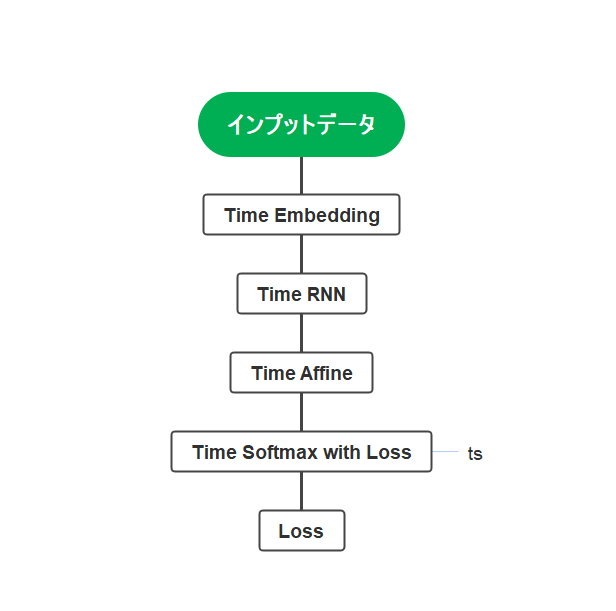

In [1]:
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *


class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f') #Embedding層用の重みを初期化
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f') #1/√nの標準偏差の分布を初期値として使う
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f') #1/√nの標準偏差の分布を初期値として使う
        rnn_b = np.zeros(H).astype('f') #バイアスとしての初期値は"0"の初期値として設定
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
 
        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W), #embedding層
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True), #RNN層、statefulはTrueにすることでTimeRNNレイヤは前の隠れ状態を引き継ぐことができるようになる。
            TimeAffine(affine_W, affine_b) #全結合層
        ]
        self.loss_layer = TimeSoftmaxWithLoss() #ソフトマックス層
        self.rnn_layer = self.layers[1] #RNN層を別に準備

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

ModuleNotFoundError: No module named 'common'

#### 
1. クラスの初期化 `__init__:
   - モデルの各層の重みとバイアスを初期化します。
   - `vocab_size`は語彙のサイズ、`wordvec_size`は単語の埋め込み（Word Embedding）の次元数、`hidden_size`はRNNの隠れ層の次元数を指定します。
   - 重み行列の初期化には、ランダムな値を用いますが、一部の行列は特定の方法で初期化されています。たとえば、埋め込み層の重みは小さなランダムな値で初期化され、RNN層の重みは平方根の逆数によってスケーリングされた値を使用して初期化されます。

2. レイヤの生成:
   - モデルの各層を生成し、リストとして保持します。このモデルには以下の層が含まれています。
     - `TimeEmbedding`: 埋め込み層
     - `TimeRNN`: リカレントニューラルネットワーク（RNN）層
     - `TimeAffine`: 全結合層
   - また、損失計算のための`TimeSoftmaxWithLoss`層も定義されています。

3. 重みと勾配の管理:
   - すべての層の重みと勾配は、`self.params`と`self.grads`というリストにまとめて管理されます。これにより、逆伝播の際に各層の重みを更新できます。

4. forward`メソッド:
   - フォワードパスを実行します。与えられた入力データ（`xs`）を埋め込み層、RNN層、全結合層の順に通して処理し、最終的な損失を計算します。
   - このメソッドはモデルの学習時に使用され、損失を返します。

5. backwardメソッド:
   - バックワードパスを実行し、勾配を計算します。損失の勾配（`dout`）を受け取り、各層の逆伝播を行い、重みの勾配を計算します。
   - このメソッドは誤差逆伝播法を用いた学習時に使用されます。

6.　reset_state`メソッド:
   - RNN層の状態をリセットするためのメソッドです。RNNは時間方向に展開され、過去の隠れ状態を保持することがあります。このメソッドは、新しいシーケンスを処理する際にRNNの状態をリセットするために使用されます。

このクラスは、言語モデルの訓練やテキスト生成などのタスクに使用できる基本的な機能を提供します。他のコードと組み合わせて、自然言語処理タスクを解決するための完全なモデルを構築することができます。

### Xavierの初期値

##### 重みは、最後に"0"に近づけば近づくほどいい学習結果となる。そのため初期値として用いる値としては、"0"として考えたくなる。ただ、これでは重みの表現力に問題が生じる。①すべての重みの初期値を"0"にして伝播すると、順伝播が同じ値となってしまい。逆伝播して重みを探索更新する際に同じように更新されて表現の幅が狭くなってしまう。②逆伝播の値が"0"に近いと重みの更新量が小さくなって、重みが停滞して学習が進まず、誤差の最小値にたどり着くのに時間がかかってしまう。

##### 解決策の1つがXavierの初期値という設定方法になる。
##### 

### 言語モデルの評価

言語モデルの評価において、Perplexity（パープレキシティ）は一般的に使用される指標の1つです。Perplexityは、言語モデルが与えられたテキストデータをどれだけよく予測できるかを示す尺度です。Perplexityが低いほど、モデルはテキストデータをより正確に予測できると言えます。

Perplexityは、言語モデルが確率分布を出力する場合に使用されます。モデルが与えられた単語の系列（テキスト）に対して、それぞれの単語の予測確率を計算し、それらの確率の逆数を取ります。具体的には以下のように計算されます：

テストデータセットを考えます。このデータセットは、モデルの性能を評価するためのテキストデータです。

テストデータセット内の各単語に対して、言語モデルによる予測確率を計算します。つまり、モデルにとってその単語が次に来る確率を求めます。

各単語の予測確率の逆数を計算し、これらの逆数の平均を取ります。これがPerplexityの値となります。


Perplexityの直感的な理解は、モデルが与えられたテキストデータの単語をどれだけ予測しやすいかを示すものです。Perplexityが低い場合、モデルはテキストデータをより正確に予測でき、より高い確信度で単語を生成できると言えます。


In [ ]:
# coding: utf-8
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from simple_rnnlm import SimpleRnnlm


# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5  # Truncated BPTTの展開する時間サイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み（データセットを小さくする）
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

# 学習時に使用する変数
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)


# １ミニバッチの各サンプルの読み込み開始位置を計算
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # ２ミニバッチの取得
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # 3エポックごとにパープレキシティの評価
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# グラフの描画
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

##### 1で各バッチでデータを読み込む開始位置をオフセットして読み込ませてます。この処理が前述のTruncated BPTTである。
##### 2は、time_idexでずらしながらシーケンシャルにデータをコーパスから取得している。
##### 3で、パープレキシティの計算を行っている。

### 6.1 RNNの問題点

[2.4684068094579303, 3.3357049741610365, 4.783279375373182, 6.279587332087612, 8.080776465019053, 10.251163032292936, 12.936063506609896, 16.276861327786712, 20.45482961834598, 25.688972842084684, 32.25315718048336, 40.48895641683869, 50.8244073070191, 63.79612654485427, 80.07737014308985, 100.5129892205125, 126.16331847536823, 158.35920648258823, 198.7710796761195, 249.495615421267]


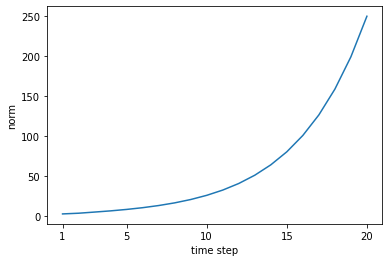

In [2]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


N = 2  # ミニバッチサイズ
H = 3  # 隠れ状態ベクトルの次元数
T = 20  # 時系列データの長さ

dh = np.ones((N, H))

np.random.seed(3)

Wh = np.random.randn(H, H)
#Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

print(norm_list)

# グラフの描画
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

勾配爆発（Gradient Explosion）:

勾配爆発は、反対に、勾配が非常に急激に増加し、非常に大きな値を取ることがある問題です。これは、RNNの再帰式において非線形活性化関数が大きな値を持つ場合に発生します。
シグモイドやtanhなどの非線形活性化関数は、入力が大きい場合に対して微分が非常に小さくなる特性があります。しかし、もし非線形関数の微分が1より大きな値を持つ場合（例えば、ReLU関数）、勾配が急激に増加し、数値的に不安定な状態になります。
勾配が爆発すると、更新される重みが非常に大きくなり、モデルの収束性が損なわれ、訓練が不安定になります。

[1.2342034047289652, 0.8339262435402591, 0.5979099219216477, 0.39247420825547574, 0.2525242645318454, 0.16017442237957713, 0.10106299614538981, 0.06358148956166684, 0.03995083909833199, 0.025086887541098325, 0.015748611904532892, 0.009884999125204758, 0.006204151282595105, 0.003893806551809953, 0.002443767399386287, 0.0015337065005571365, 0.0009625497320203265, 0.0006040924319556741, 0.00037912574706291106, 0.00023793756048323344]


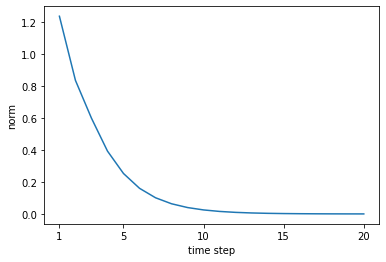

In [3]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


N = 2  # ミニバッチサイズ
H = 3  # 隠れ状態ベクトルの次元数
T = 20  # 時系列データの長さ

dh = np.ones((N, H))

np.random.seed(3)
Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

print(norm_list)

# グラフの描画
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

勾配消失（Gradient Vanishing）:

勾配消失は、RNNモデルが長い系列データを扱う際によく発生します。RNNは過去の情報を保持するため、長い系列の場合、過去の情報が現在の予測にほとんど影響を与えなくなります。
配が時間ステップをさかのぼって伝播されます。しかし、非線形活性化関数（特にシグモイド関数）の微分はその入力値に対して最大値が1以下であるため、時間が経過するにつれて勾配が繰り返し小さくなり、最終的にゼロに近づきます。
結果として、過去の情報が現在の予測にほとんど影響を与えなくなり、モデルの長期的な依存性を捉えることができなくなります。

#### 勾配消失と勾配爆発の対応策

勾配消失と勾配爆発を克服するためのいくつかのアプローチが存在します。例えば：

勾配クリッピング（Gradient Clipping）：勾配が一定の閾値を超えないようにクリップする方法です。これにより、勾配爆発を防ぐのに役立ちます。

ゲート付きRNN（GRUやLSTM）：通常のRNNよりも長期の依存性をキャプチャするために設計された、ゲート制御されたリカレントユニットを使用することがあります。

Layer NormalizationやBatch Normalization：層ごとの正規化を使用して、勾配の安定性を向上させる方法です。

適切な初期化方法：重みの初期値設定方法を工夫することで、勾配消失や勾配爆発を軽減することができます。

In [5]:
#勾配クリッピングのコーディング
# coding: utf-8
import numpy as np


dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0


def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


print('before:', dW1.flatten())
clip_grads(grads, max_norm)
print('after:', dW1.flatten())

before: [6.49144048 2.78487283 6.76254902 5.90862817 0.23981882 5.58854088
 2.59252447 4.15101197 2.83525082]
after: [1.49503731 0.64138134 1.55747605 1.36081038 0.05523244 1.28709139
 0.59708178 0.95601551 0.65298384]
